## Impressions and Reviews  
- avg_times_up_user, avg_days_up_user, n_user_items 를 생성하여 좋은 성능
- item의 description과 title에 대해 tfidf, countvect를 사용하여 추가 feature 사용
- matplotlib 의 venndiagram을 사용

In this kernel we will take a look at engineering aggregated features. Specifically, we will engineer 3 aggregated features using `train_active.csv`, `test_active.csv`, `periods_test.csv` and `periods_test.csv`. Those features will be:
- `avg_times_up_user` - how often the average item of the user has been put up for sale.
- `avg_days_up_user` - the average number of days an item from the user has been put up for sale.
- `n_user_items` - the number of items the user has put up for sale.

Let's see if they help :)

# Engineering aggregated features

In [5]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

sns.set()
%matplotlib inline

Start with loading the data. To save some memory, we only load `item_id` and `user_id`, as that's all we need for the proposed features.

In [6]:
# 'item_id', 'user_id' 두개 feature만 load (memory문제)
used_cols = ['item_id', 'user_id']

train = pd.read_csv('/content/train.csv', usecols=used_cols)
train_active = pd.read_csv('/content/train_active.csv', usecols=used_cols)
test = pd.read_csv('/content/test.csv', usecols=used_cols)
test_active = pd.read_csv('/content/test_active.csv', usecols=used_cols)

train_periods = pd.read_csv('/content/periods_train.csv', parse_dates=['date_from', 'date_to'])
test_periods = pd.read_csv('/content/periods_test.csv', parse_dates=['date_from', 'date_to'])

train.head()

,item_id,user_id
0,b912c3c6a6ad,e00f8ff2eaf9
1,2dac0150717d,39aeb48f0017
2,ba83aefab5dc,91e2f88dd6e3
3,02996f1dd2ea,bf5cccea572d
4,7c90be56d2ab,ef50846afc0b


In [25]:
print(train.shape, test.shape)

(1503424, 29) (508438, 28)


It's time for some visualizations. The following venn diagrams show the overlap of the user ID between the relevant dataframes. If this overlap is reasonably large, it might be a good idea to use the aggregated features.

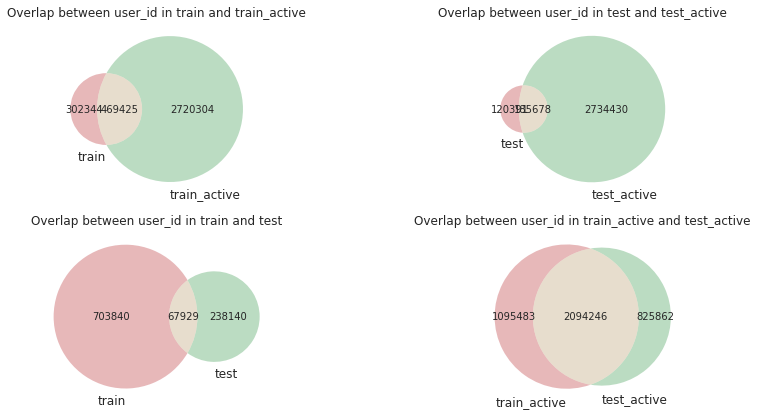

In [7]:
# from matplotlib_venn import venn2, venn2_circles - 벤다이어그램 지원
fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

# 겹치는 id를 확인하기 위한 벤다이어그램 plot
# data 간에 id가 겹치는 data가 많으면 해당 data들을 사용
def get_venn(axarr, feature):
    axarr[0, 0].set_title(f'Overlap between {feature} in train and train_active')
    venn2([
        set(train[feature].values), 
        set(train_active[feature].values)
    ], set_labels = ('train', 'train_active'), ax=axarr[0, 0])

    axarr[0, 1].set_title(f'Overlap between {feature} in test and test_active')
    venn2([
        set(test[feature].values), 
        set(test_active[feature].values)
    ], set_labels = ('test', 'test_active'), ax=axarr[0, 1])

    axarr[1, 0].set_title(f'Overlap between {feature} in train and test')
    venn2([
        set(train[feature].values), 
        set(test[feature].values)
    ], set_labels = ('train', 'test'), ax=axarr[1, 0])

    axarr[1, 1].set_title(f'Overlap between {feature} in train_active and test_active')
    venn2([
        set(train_active[feature].values), 
        set(test_active[feature].values)
    ], set_labels = ('train_active', 'test_active'), ax=axarr[1, 1])
    
get_venn(axarr, 'user_id')

We're lucky! There is a huge overlap between the IDs of `train` / `train_active` and `test` / `test_active`. Out of curiosity, we'll also take a look at the overlap of item ID. This should (hopefully) not overlap at all.

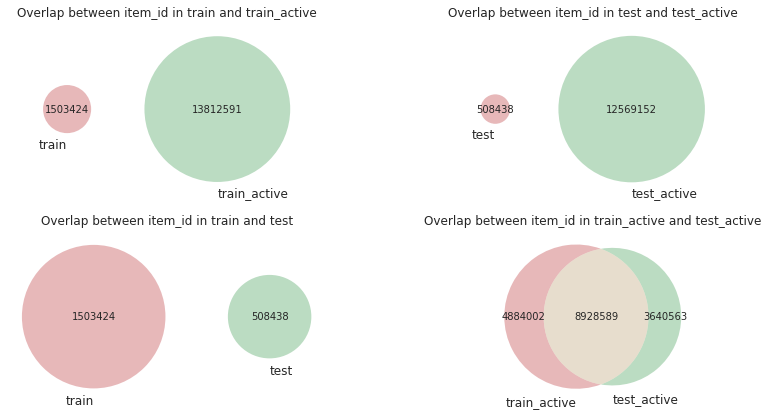

In [8]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 7))

get_venn(axarr, 'item_id')

As suspected, there is no overlap between the dataframes. Except of `train_active` and `test_active`. These might be duplicated rows or items that have been put up for sale multiple times. We will have to filter these duplicated IDs for our engineered features.

Anyway, we will now merge the data into one dataframe and, as mentioned, drop the duplicate item IDs. At this point we can also delete `train_active` and `test_active` to free up some memory.

In [9]:
# 전체 data concat
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)

# 중복 item_id data 제거
all_samples.drop_duplicates(['item_id'], inplace=True)

del train_active
del test_active
gc.collect()

7457

We will also concatenate the train and test period data to one dataframe for easier processing.

In [10]:
# processing위해서 전체 dataset concat
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

all_periods.head()

,item_id,activation_date,date_from,date_to
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28


Now the interesting part begins! For our feature `avg_days_up_user`, we first have to calculate the number of days every item has been put up. This can easily be done with pandas's `dt` API.

In [11]:
# 물건이 진열된 기간 (days_up)
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

Because we want the sum of days one item has been put up for sale, we will group by `item_id` and sum the `days_up` column. We will also count the number of items in an item ID group for our second feature, `avg_times_up_user`.

In [12]:
# item별 days_up의 sum과 count 계산 및 dataframe화 (gp_df)
# days_up_sum : 해당item이 총 몇일간 게시되었나
# times_put_up : 해당item이 몇번 게시되었나
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum'] = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

,item_id,days_up_sum,times_put_up
0,00000077ff21,13,1
1,000002c54018,6,1
2,000005570503,1,1
3,0000060018e6,6,1
4,000006497719,19,2


At this point, we have 2 scalars associated with every `item_id` appearing in train and test periods. We can now savely drop the duplicate item IDs in the `all_periods` dataframe and merge the features back into `all_periods`.

In [13]:
# 전체 period data에 대해 중복item row 제거 후 
# item별 days_up.sum과 days_up.count feature를 merge
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3


In [14]:
del gp
del gp_df
gc.collect()

48

We have an interesting but kind of useless feature now. As seen in the second venn diagram, there is no overlap at all between `train_active` (and with that `train_periods`) and `train` concerning *item* IDs. For the feature to become useful, we somehow have to associate an item ID with a user ID.

So the next step is to merge `all_samples` into `all_periods`. This will get us a user ID for every item ID in the periods dataframes. Now there is an overlap!

In [15]:
# all period, all_sample을 merge함으로써 item_id마다 user_id 부여
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

,item_id,activation_date,date_from,date_to,days_up,days_up_sum,times_put_up,user_id
0,8f5caef7afb0,2017-02-14,2017-03-15,2017-03-16,1,17,4,e292cce69842
1,66218ff526d1,2017-02-16,2017-03-15,2017-03-18,3,18,3,a326c04a24ec
2,b237d9539b21,2017-03-01,2017-03-15,2017-03-28,13,19,2,06d275498a56
3,80bf58082ad3,2017-03-19,2017-03-19,2017-03-28,9,17,4,831c8c4a622c
4,67a9944a7373,2017-03-14,2017-03-15,2017-03-28,13,18,3,248102e50d79


The next problem is that there are multiple features for a user if that user has put up more than one item that appears in `train_active` / `test_active`. We will have to somehow reduce this to one feature.

Here they are averaged, but you can try something else like median or modus too.

In [16]:
# active data에서 나타난 여러개의 물건을 게시했을 수 있으므로 이에 대한 days_up.mean 사용 (median, modus 가능)
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum': 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })
gp.head()

,user_id,avg_days_up_user,avg_times_up_user
0,00000077ff21,12.5,2.00
1,000006497719,19.0,2.00
2,00000b4d72f6,3.0,1.00
3,00000d642d7e,13.0,1.00
4,0000126b80a4,12.0,1.75


For our last feature, `n_user_items`, we just group by user ID and count the number of items. We have to be careful to use `all_samples` instead of `all_periods` here because the latter does not contain the `train.csv` and `test.csv` samples.

In [17]:
# user별 item개수 계산 후 "all_sample"과 merge (train 또는 test data를 포함하지 않으므로 all_period와 merge X)
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

,user_id,avg_days_up_user,avg_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,2
1,000006497719,19.0,2.00,1
2,00000b4d72f6,3.0,1.00,1
3,00000d642d7e,13.0,1.00,2
4,0000126b80a4,12.0,1.75,8


I'll save the features to a CSV so you don't have to run the entire code yourself if you want to try them in your model.

In [18]:
# 중간에 data 저장
gp.to_csv('aggregated_features.csv', index=False)

In [19]:
del all_samples
del all_periods
del train
del test

gc.collect()

12

# Training a LightGBM model

In [20]:
# 전체 data에 생성한 data를 merge
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp
gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,1


One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [21]:
# train, test 모두 있지 않으면 nan발생 -> 결측치 존재
train[agg_cols].isna().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [22]:
test[agg_cols].isna().any(axis=1).sum() / len(test) * 100

24.354198545348694

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

In [23]:
# feature engineering 실시
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

for df in [train, test]:
    # description과 title에 결측치 'unknown-'으로 fill
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    # description과 title의 글자 수 feature 생성
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))
    
    # description과 title의 unique words 수 비율 feature 생성
    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    # region + city 변수 통합
    df['city'] = df['region'] + '_' + df['city']

    # description에서 punctuation의 개수
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)

In [ ]:
# item title을 count_vectorize, item description을 TfidfVectorize 수행 -> feature 생성
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

In [ ]:
# 예측할 변수 (Y)
target = 'deal_probability'

# 예측에 사용할 변수 (X)
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]

# 명목형변수 (X)
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

In [ ]:
# categorical은 label_encoding 수행
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [ ]:
# max_depth 제한, learning rate을 높임으로써 조절
rounds = 16000
early_stop_rounds = 500
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 32,
    'max_depth': 15,
    'learning_rate' : 0.02,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

In [ ]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=42)

x_train = scipy.sparse.hstack([
        train_desc_counts[train_index],
        train_title_counts[train_index],
        train.loc[train_index, predictors]
], format='csr')
y_train = train.loc[train_index, target]

x_valid = scipy.sparse.hstack([
    train_desc_counts[valid_index],
    train_title_counts[valid_index],
    train.loc[valid_index, predictors]
], format='csr')
y_valid = train.loc[valid_index, target]

x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

dtrain = lgb.Dataset(x_train, label=y_train,
                     feature_name=list(feature_names), 
                     categorical_feature=categorical)
dvalid = lgb.Dataset(x_valid, label=y_valid,
                     feature_name=list(feature_names), 
                     categorical_feature=categorical)

In [ ]:
evals_result = {}
model = lgb.train(params, dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train', 'valid'],
                  num_boost_round=rounds, 
                  early_stopping_rounds=early_stop_rounds, 
                  verbose_eval=500)

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

In [ ]:
# feature importance 시각화 - avg_days_up, avg_times_up_user and n_user_items 중요
fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [ ]:
subm = pd.read_csv('/content/sample_submission.csv')
subm['deal_probability'] = np.clip(model.predict(x_test), 0, 1)
subm.to_csv('submission.csv', index=False)

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!